In [1]:
# 作业要求:根据收集来的资料，判断每个人其年收入是否高于50000美元，用Logistic regression和Generative model两种方法来实现
# 环境：Anaconda3+Jupyter Notebook，python3.6.8

In [2]:
# 0.开始之前导入需要用到的库+添加路径
import numpy as np
# Python的一个扩展程序库，支持大量的维度数组与矩阵运算
np.random.seed(0)
# 生成随机数
X_train_fpath = './X_train'
Y_train_fpath = './Y_train'
X_test_fpath = './X_test'
output_fpath = './output_{}.csv'# 用于测试集的预测输出
# 添加文件路径

In [3]:
# 1.加载数据
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
# 解析csv文件到numpy数组

In [4]:
# 2.归一化：编写一个_normalize()函数对数据进行预处理：归一化，即每个数据特征的均值和标准差进行归一化
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # 这个函数对X的特定列进行归一化。
    # 在处理测试数据时，训练数据的平均值和标准方差将被重新使用
    #
    # 参数:
    #     X: 要处理的数据
    #     train:处理训练数据时为True，测试数据为False
    #     specific_column:将被归一化的列的索引。如果'None'，所有列将被归一化。
    #     X_mean:训练数据的平均值，当train = 'False'时使用
    #     X_std:训练数据的标准偏差，当train = 'False'时使用
    # 输出:
    #     X:归一化化数据
    #     X_mean:训练数据的计算平均值
    #     X_std:训练数据的计算标准差

    if specified_column == None:
        specified_column = np.arange(X.shape[1])# 为每个数据添加索引
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)
        # 求取每个数据的平均值和标准差

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
    # 归一化数据 
    return X, X_mean, X_std
    # 返回归一化后的数据，均值，标准差

In [5]:
# 3.分割训练集-验证集
def _train_dev_split(X, Y, dev_ratio = 0.25):
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

In [6]:
# 4.归一化处理训练数据和测试数据
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
# 5.将数据划分为训练集和验证集
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)
train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))



Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


In [7]:
# 6.定义一些有用的函数
# _shuffle：打乱数据顺序，类似于重新洗牌，进行分批次训练（即每次将一部分数据喂给模型进行训练，计算损失）
# _sigmoid：激活函数
# _f（X，w，b）：向前传播，计算激活值
# _predict(X, w, b)：预测
# _accuracy(Y_pred, Y_label)：计算准确度
# _cross_entropy_loss：交叉熵损失函数
# _gradient：计算梯度值，用于更新w和b
def _shuffle(X, Y):# 这个函数将两个等长的列表/数组X和Y混合在一起。
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):# Sigmoid函数可以用来计算概率。为避免溢出，设置最小/最大输出值。
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):# 这是由w和b参数化的线性回归函数
    # 参数：
    #     X:输入数据，形状= [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension，]
    #     b:偏见，标量
    # 输出:
    #     X每一行被正标记的预测概率，shape = [batch_size，]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):# 这个函数为每一行X返回一个真值预测，通过舍入逻辑回归函数的结果。
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):# 这个函数计算预测精度
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc
def _cross_entropy_loss(y_pred, Y_label): # 这个函数计算。
    # 参数:
    #     y_pred: 概率预测，浮点向量
    #     Y_label: 真值标签，bool向量
    # 输出:
    #     交叉熵, 标量
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):# 这个函数计算交叉熵损失的梯度与权重w和偏差b。
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


In [8]:
# 7.训练
# 我们使用小批次梯度下降法来训练。训练资料被分为许多小批次，针对每一个小批次，我们分别计算其梯度以及损失，
# 并根据该批次来更新模型的参数。当一次回圈完成，也就是整个训练集的所有小批次都被使用过一次以后，
# 我们将所有训练资料打散并且重新分成新的小批次，进行下一个回圈，直到事先设定的回圈数量达成为止。

# 将w和b初始化为0
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# 设置其他参数（迭代次数，分批次大小，学习率）  
max_iter = 10
batch_size = 8
learning_rate = 0.2

# 创建列表用来保存训练集和验证集的损失值和准确度
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# 用来更新学习率
step = 1

# 训练
for epoch in range(max_iter):
    # 每个epoch都会重新洗牌
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # 分批次训练
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # 计算梯度值
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # 更新参数w和b
        # 学习率随着迭代时间增加而减少
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
    # 参数总共更新了max_iter × （train_size/batch_size）次     
    # 计算训练集的损失值和准确度
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)
    # 计算验证集的损失值和准确度
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))


Training loss: 0.27135543524640593
Development loss: 0.2896359675026286
Training accuracy: 0.8836166291214418
Development accuracy: 0.8733873940287504


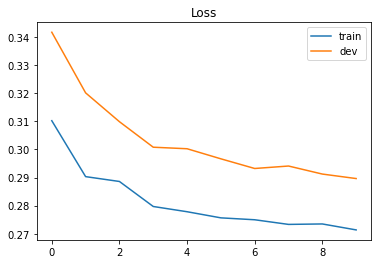

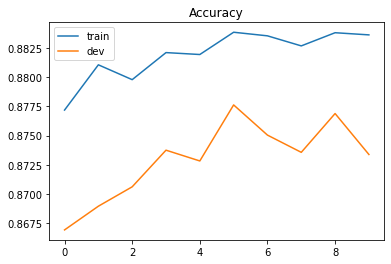

In [9]:
# 8.绘制损失和精度曲线
import matplotlib.pyplot as plt # 一个强大的绘图工具库
# 损失曲线
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# 精度曲线
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

In [10]:
# 9.预测测试标签
# 预测测试集的资料标签并且存在output_logistic.csv中
#在测试集上进行预测
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# 打印出最重要的权重
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Not in universe -4.031960278019252
 Spouse of householder -1.6254039587051399
 Other Rel <18 never married RP of subfamily -1.4195759775765402
 Child 18+ ever marr Not in a subfamily -1.295857207666473
 Unemployed full-time 1.1712558285885906
 Other Rel <18 ever marr RP of subfamily -1.1677918072962366
 Italy -1.093458143800618
 Vietnam -1.0630365633146412
num persons worked for employer 0.9389922773566489
 1 0.8226614922117187


In [11]:
# 10.方法二：generative model
# Generative model方法跟Logistic regression方法类似，不同之处在于
# Generative model可以直接计算出w和b的最佳解，而Logistic regression是将w和b进行初始化，
# 通过迭代训练来更新w和b。

# 解析csv文件到numpy数组
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# 归一化训练和测试数据
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [12]:
# 11.均值和协方差
# 在generative model 中，我们需要分别计算两个类别内的资料平均与共变异。

# 计算两个类别的均值
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# 计算两个类别的协方差
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# 共享协方差是类别内个体协方差的加权平均值
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

In [ ]:
# 12.计算权重和偏差
# 计算协方差矩阵逆
# 由于协方差矩阵可能是近乎基数的，np. linalginv()可能会给出一个很大的数值误差。
# 通过SVD分解，可以高效准确地求出矩阵的逆
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# 直接计算权重和偏差
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# 计算训练集的
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))